https://www.kaggle.com/datasets/andrewmvd/data-analyst-jobs

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
df = pd.read_csv('DataAnalyst.csv')
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


## Cleaning the Dataset

In this dataset, null values are indicated by a "-1". Since this won't show up as a null value during data exploration, all values equalling -1 will be converted to NaNs. 

In [3]:
df = df.replace('-1', None)
df = df.replace(-1, None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         2253 non-null   int64 
 1   Job Title          2253 non-null   object
 2   Salary Estimate    2252 non-null   object
 3   Job Description    2253 non-null   object
 4   Rating             1981 non-null   object
 5   Company Name       2252 non-null   object
 6   Location           2253 non-null   object
 7   Headquarters       2081 non-null   object
 8   Size               2090 non-null   object
 9   Founded            1593 non-null   object
 10  Type of ownership  2090 non-null   object
 11  Industry           1900 non-null   object
 12  Sector             1900 non-null   object
 13  Revenue            2090 non-null   object
 14  Competitors        521 non-null    object
 15  Easy Apply         80 non-null     object
dtypes: int64(1), object(15)
memory usage: 281.

In [4]:
# Sample of attribute exploration. This has been performed for all features, but only one sample attribute has been kept
# as to reduce the amount of space taken up by this analysis. 
df['Industry'].value_counts()

IT Services                            325
Staffing & Outsourcing                 323
Health Care Services & Hospitals       151
Computer Hardware & Software           111
Consulting                             111
                                      ... 
Truck Rental & Leasing                   1
News Outlet                              1
Catering & Food Service Contractors      1
Chemical Manufacturing                   1
Hotels, Motels, & Resorts                1
Name: Industry, Length: 88, dtype: int64

The attributes "Competitors" and "Easy Apply" will be dropped, as they contain mostly null values and are of little interest to this assessment. 

Moving forward, this analysis will make the presumption that job seekers generally care about some of these remaining attributes far more than others. The goal in this feature selection will be to best map this preference in a workable way. The additional attributes that will be dropped are:
- "Company Name": important to the job seeker, but not useful in clustering when there are no associated company features by which to compare companies to each other. 
- "Headquarters": Most job seekers likely do not hold strong preferences here.
- "Type of ownership": Heavily imbalanced and usually of relatively little consideration.
- "Industry": Could be rather useful, but highly obfuscated by the fact that many jobs are listed through a staffing agency that are irrelevant to the job itself, and that generic categories like "IT Serivces" are often used. Additionally, the "Sector" attribute already captures much of the desired information.
- "Revenue": A plurality of these are unknown, and startup status will be captured by other features. 

The follow attributes will be reworked into new ones:
- "Unnamed: 0": Will be renamed as "Job ID" for the purpose of this analysis. 
- "Job Title": Will need to be reduced into more easily useable bins, as many job titles are tantamount to each other and differ primarily in a semantic sense. 
- "Salary Estimate": Will be converted into a more useable numeric format consisting of the median between the two values.
- "Job Description": Will be vectorized as to be useable by data analysis tools.
- "Founded": Will be converted to "Company Age", then binned. This should be useful as job seekers likely have a preference in working for a recent startup or not. 

In [5]:
# Dropping the unnecessary columns
cols_to_drop = ['Competitors', 'Easy Apply', 'Company Name', 'Headquarters', 'Type of ownership', 'Industry', 'Revenue']
df.drop(cols_to_drop, axis=1, inplace=True)

# Renaming the ID column
df.rename(columns={'Unnamed: 0': 'Job ID'}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job ID           2253 non-null   int64 
 1   Job Title        2253 non-null   object
 2   Salary Estimate  2252 non-null   object
 3   Job Description  2253 non-null   object
 4   Rating           1981 non-null   object
 5   Location         2253 non-null   object
 6   Size             2090 non-null   object
 7   Founded          1593 non-null   object
 8   Sector           1900 non-null   object
dtypes: int64(1), object(8)
memory usage: 158.5+ KB


Since the 'Founded' attributes contains significantly more null values than the other columns, the null values will be imputed with the attribute median. The median is used in this case to account for the skew of the data, represented in the histogram below. 

Other values that are straightforward to impute, such as the numeric values of 'Rating', will be similarly handled. 

<AxesSubplot: title={'center': 'Founded'}, ylabel='Frequency'>

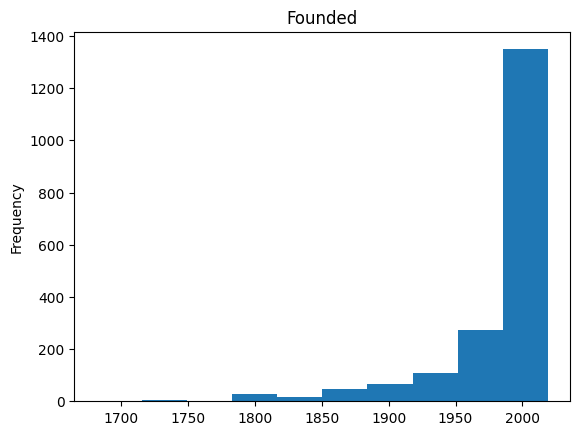

In [14]:
df['Founded'].plot(kind='hist', title='Founded')

<AxesSubplot: title={'center': 'Rating'}, ylabel='Frequency'>

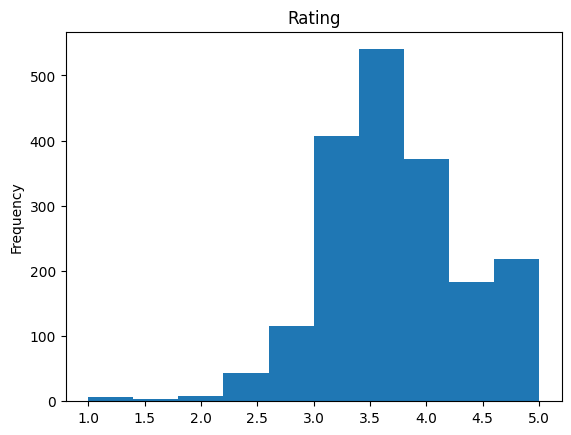

In [15]:
df['Rating'].plot(kind='hist', title='Rating')

In [8]:
df['Founded'].fillna(df['Founded'].median(), inplace=True)
df['Rating'].fillna(df['Rating'].median(), inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1899 entries, 0 to 2252
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Job ID           1899 non-null   int64  
 1   Job Title        1899 non-null   object 
 2   Salary Estimate  1899 non-null   object 
 3   Job Description  1899 non-null   object 
 4   Rating           1899 non-null   float64
 5   Location         1899 non-null   object 
 6   Size             1899 non-null   object 
 7   Founded          1899 non-null   float64
 8   Sector           1899 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 148.4+ KB


Dropping the null values after imputation results in merely a 16% reduction of the dataset vs 31% without the imputation. 

Next, values in 'Salary Estimate' will be replaced with the mean of their range. A function will loop through the database here, as it is more complex than a simple mathematical computation of an existing numeric attribute. The 'findall' regex function makes this more difficult to weave into a Pandas replace function. 

In [9]:
for i in range(len(df['Salary Estimate'])):
    text = df.iloc[i, 2]
    new_vals = re.findall('[0-9]+𝐾*', text)
    new_vals = list(map(int, new_vals))
    new_mean = np.mean(new_vals)
    df.iloc[i, 2] = new_mean
    
df.head()

,Job ID,Job Title,Salary Estimate,Job Description,Rating,Location,Size,Founded,Sector
0,0,"Data Analyst, Center on Immigration and Justic...",51.5,Are you eager to roll up your sleeves and harn...,3.2,"New York, NY",201 to 500 employees,1961.0,Non-Profit
1,1,Quality Data Analyst,51.5,Overview\n\nProvides analytical and technical ...,3.8,"New York, NY",10000+ employees,1893.0,Health Care
2,2,"Senior Data Analyst, Insights & Analytics Team...",51.5,We’re looking for a Senior Data Analyst who ha...,3.4,"New York, NY",1001 to 5000 employees,2003.0,Information Technology
3,3,Data Analyst,51.5,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,"New York, NY",201 to 500 employees,2002.0,Information Technology
4,4,Reporting Data Analyst,51.5,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,"New York, NY",501 to 1000 employees,2009.0,"Arts, Entertainment & Recreation"


In [18]:
df['Job Title'].value_counts()[:25]

Data Analyst                            333
Senior Data Analyst                      77
Junior Data Analyst                      30
Business Data Analyst                    25
Data Quality Analyst                     17
Sr. Data Analyst                         17
Data Analyst Junior                      17
Data Analyst II                          14
Lead Data Analyst                        13
Data Governance Analyst                  13
Data Reporting Analyst                   12
Data Analyst I                           10
Data Analyst III                         10
Financial Data Analyst                    9
Sr Data Analyst                           9
Marketing Data Analyst                    7
SQL Data Analyst                          7
Data Management Analyst                   7
Data Warehouse Analyst                    6
Data Security Analyst                     6
Technical Data Analyst                    6
Clinical Data Analyst                     5
Product Data Analyst            